# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [34]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/datskiw/KTH/ID2223/labs/mlfs-book
HopsworksSettings initialized!


In [35]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [36]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 15, 31, 38, 326852)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [37]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 15:31:40,439 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:31:40,443 INFO: Initializing external client
2025-11-16 15:31:40,443 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 15:31:41,027 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 15:31:41,810 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286300


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [38]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=6,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 15:31:49,128 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/489094 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/59303 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21613 elapsed<00:00 remaining<?

In [39]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.4920423E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [40]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-20 00:00:00+00:00,2.25,0.7,8.854829,63.435013,Stockholm
1,2025-11-18 00:00:00+00:00,-0.65,0.0,7.200000,270.000000,Stockholm
2,2025-11-17 00:00:00+00:00,0.10,0.0,13.246826,312.797394,Stockholm
3,2025-11-19 00:00:00+00:00,0.70,0.0,6.162207,353.290253,Stockholm
4,2025-11-21 00:00:00+00:00,1.10,0.0,13.320000,360.000000,Stockholm


In [41]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
dtypes: datetime64[us, Etc/UTC](1), float32(4), object(1)
memory usage: 288.0+ bytes


In [42]:
# Retrieve the latest 3 air quality records (sorted by date descending)
air_fg = fs.get_feature_group(
    name='air_quality',
    version=3,
)

air_quality_df = air_fg.read()
air_quality_recent = air_quality_df.sort_values("date", ascending=False).head(3)
air_quality_recent

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


,date,pm25,country,city,street,url,pm25_rolling_3d_mean
1945,2025-11-15 00:00:00+00:00,2.0,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.166667
458,2025-11-13 00:00:00+00:00,0.2,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.100000
213,2025-11-12 00:00:00+00:00,0.3,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.076667


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [53]:
# Autoregressive multi-day PM2.5 forecast using the latest 3 values (historical or inferred)

# Ensure forecast weather data is sorted by date
batch_data = batch_data.sort_values("date", ascending=True).copy()

# Initialize the last 3 pm25 values from the most recent historical data
# (we sort ascending so the last 3 entries are the latest in time)
last_three_pm25 = list(air_quality_recent.sort_values("date", ascending=True)["pm25"].values)

predictions = []
rolling_means = []

for _, row in batch_data.iterrows():
    # Use the mean of the last 3 pm25 values as in training (pm25_rolling_3d_mean)
    pm25_rolling_3d_mean = float(np.mean(last_three_pm25))
    rolling_means.append(pm25_rolling_3d_mean)

    features = pd.DataFrame({
        "pm25_rolling_3d_mean": [pm25_rolling_3d_mean],
        "temperature_2m_mean": [row["temperature_2m_mean"]],
        "precipitation_sum": [row["precipitation_sum"]],
        "wind_speed_10m_max": [row["wind_speed_10m_max"]],
        "wind_direction_10m_dominant": [row["wind_direction_10m_dominant"]],
    })

    # Predict next day's pm25
    pm25_pred = float(retrieved_xgboost_model.predict(features)[0])
    predictions.append(pm25_pred)

    # Update the list of last 3 pm25 values with the new prediction (autoregressive)
    last_three_pm25.append(pm25_pred)
    if len(last_three_pm25) > 3:
        last_three_pm25.pop(0)

# Attach predictions and rolling feature to batch_data for downstream plotting and monitoring
batch_data["pm25_rolling_3d_mean"] = np.array(rolling_means, dtype="float32")
batch_data["predicted_pm25"] = np.array(predictions, dtype="float32")
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_rolling_3d_mean,street,country,days_before_forecast_day
2,2025-11-17 00:00:00+00:00,0.10,0.0,13.246826,312.797394,Stockholm,0.944566,0.833333,Rosenlundsgatan,Sweden,1
1,2025-11-18 00:00:00+00:00,-0.65,0.0,7.200000,270.000000,Stockholm,0.773689,1.048189,Rosenlundsgatan,Sweden,2
3,2025-11-19 00:00:00+00:00,0.70,0.0,6.162207,353.290253,Stockholm,0.989981,1.239418,Rosenlundsgatan,Sweden,3
0,2025-11-20 00:00:00+00:00,2.25,0.7,8.854829,63.435013,Stockholm,1.616747,0.902745,Rosenlundsgatan,Sweden,4
4,2025-11-21 00:00:00+00:00,1.10,0.0,13.320000,360.000000,Stockholm,0.665678,1.126806,Rosenlundsgatan,Sweden,5


In [ ]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [54]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25_rolling_3d_mean,street,country,days_before_forecast_day
2,2025-11-17 00:00:00+00:00,0.10,0.0,13.246826,312.797394,Stockholm,0.944566,0.833333,Rosenlundsgatan,Sweden,1
1,2025-11-18 00:00:00+00:00,-0.65,0.0,7.200000,270.000000,Stockholm,0.773689,1.048189,Rosenlundsgatan,Sweden,2
3,2025-11-19 00:00:00+00:00,0.70,0.0,6.162207,353.290253,Stockholm,0.989981,1.239418,Rosenlundsgatan,Sweden,3
0,2025-11-20 00:00:00+00:00,2.25,0.7,8.854829,63.435013,Stockholm,1.616747,0.902745,Rosenlundsgatan,Sweden,4
4,2025-11-21 00:00:00+00:00,1.10,0.0,13.320000,360.000000,Stockholm,0.665678,1.126806,Rosenlundsgatan,Sweden,5


In [55]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 2 to 4
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   predicted_pm25               5 non-null      float32                
 7   pm25_rolling_3d_mean         5 non-null      float32                
 8   street                       5 non-null      object                 
 9   country                      5 non-null      object                 
 10  days_before

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

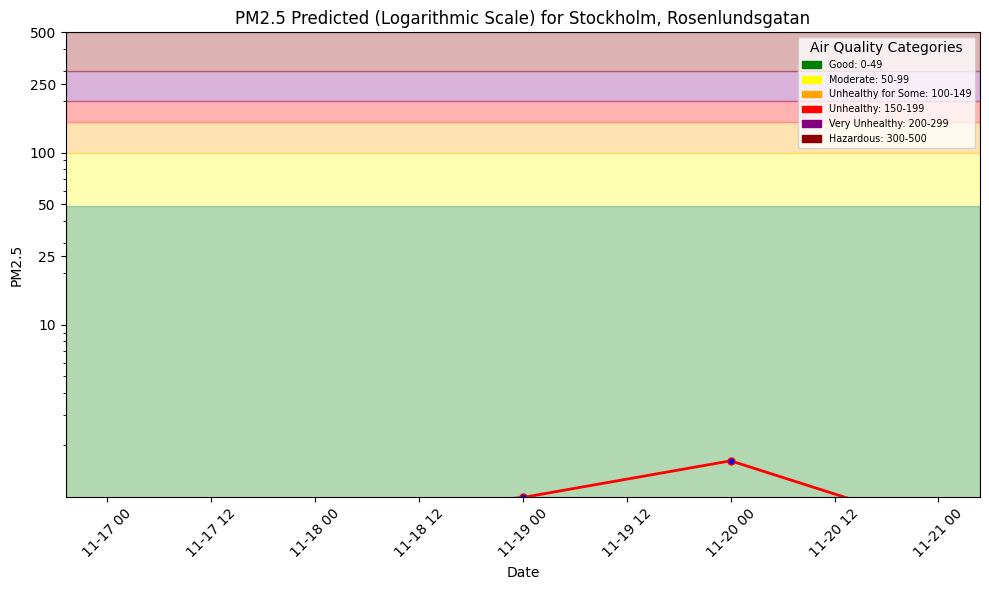

In [56]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [57]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [58]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286300/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-16 15:45:03,177 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:45:06,350 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:46:51,170 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:46:51,320 INFO: Waiting for log aggregation to finish.
2025-11-16 15:46:59,896 INFO: Execution finished successfully.


(Job('aq_predictions_3_offline_fg_materialization', 'SPARK'), None)

In [ ]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_3d_mean,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,2.3,0.0,9.449572,229.635544,Stockholm,0.166667,35.337685,Rosenlundsgatan,Sweden,1
1,2025-11-17 00:00:00+00:00,0.1,0.0,13.246826,312.797394,Stockholm,0.833333,0.944566,Rosenlundsgatan,Sweden,1


In [60]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=3)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.59s) 


,date,pm25,country,city,street,url,pm25_rolling_3d_mean
0,2025-08-24 00:00:00+00:00,0.00,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.023333
1,2024-02-06 00:00:00+00:00,0.27,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.200000
2,2021-10-09 00:00:00+00:00,5.97,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,4.283333
3,2024-08-28 00:00:00+00:00,0.53,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,1.043333
4,2020-10-28 00:00:00+00:00,3.80,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,5.516666
...,...,...,...,...,...,...,...
1941,2023-07-16 00:00:00+00:00,0.43,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.243333
1942,2024-12-18 00:00:00+00:00,0.13,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.100000
1943,2021-01-28 00:00:00+00:00,2.60,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,1.556667
1944,2025-06-08 00:00:00+00:00,0.10,Sweden,Stockholm,Rosenlundsgatan,https://api.waqi.info/feed/A129124,0.286667


In [62]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.45s) 


ValueError: feature_names mismatch: ['pm25_rolling_3d_mean', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
expected pm25_rolling_3d_mean in input data

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

---